In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report
)
from imblearn.over_sampling import ADASYN
import optuna
from optuna.visualization.matplotlib import plot_contour, plot_parallel_coordinate
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

In [3]:
import pandas as pd

# Data Paths
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load datasets
static_vars_df = pd.read_parquet(STATIC_PATH)
obs_df = pd.read_parquet(OBS_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

print('static_vars_df head:')
print(static_vars_df.head())
print('\nobs_df head:')
print(obs_df.head())

static_vars_df head:
        NHDPlusID       variable          value
0  55000900028341  aspect_ne_pct       0.074821
1  55000900028341  aspect_sw_pct       0.007807
2  55000900028341  aspect_nw_pct       0.917372
3  55000900028341  aspect_se_pct       0.000000
4  55000900028341    elev_min_cm  103297.000000

obs_df head:
        NHDPlusID SiteIDCode        Date       variable     value
0  55000900130309     GSWS01  1980-01-01  Discharge_CMS  0.045505
1  55000900130309     GSWS01  1980-01-02  Discharge_CMS  0.043410
2  55000900130309     GSWS01  1980-01-03  Discharge_CMS  0.048592
3  55000900130309     GSWS01  1980-01-04  Discharge_CMS  0.061872
4  55000900130309     GSWS01  1980-01-05  Discharge_CMS  0.276599


In [4]:
# Pivot static vars (each variable as a column)
static_wide = static_vars_df.pivot(index='NHDPlusID', columns='variable', values='value').reset_index()

# Pivot obs_df (Date as rows, variable as columns)
obs_wide = obs_df.pivot_table(index=['NHDPlusID', 'Date'], columns='variable', values='value').reset_index()

# Merge static features into each site’s obs
merged_df = obs_wide.merge(static_wide, on='NHDPlusID', how='left')

# Sort and forward-fill
merged_df = merged_df.sort_values(['NHDPlusID', 'Date']).ffill()
merged_df.head()


variable,NHDPlusID,Date,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm,ArbolateSu,AreaSqKm,...,aspect_se_pct,aspect_sw_pct,curv_mean,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct
0,55000900027171,2020-08-12,NaN,0.00,NaN,0.0,0.0,0.0,0.100818,0.0017,...,0.0000,1.000000,63.946892,63.048618,66223.0,58209.588235,57898.0,51722.0,63.946892,63.048618
1,55000900027173,2020-08-12,NaN,0.75,NaN,1.0,0.0,7.0,0.297666,0.1235,...,0.0000,0.565992,42.080586,41.399857,103022.0,88853.689879,88575.0,74487.0,42.080586,41.399857
2,55000900027174,2020-08-12,NaN,1.00,NaN,1.0,0.0,5.5,0.410513,0.0923,...,0.0000,0.000000,55.872930,56.605061,96559.0,79958.395450,80669.0,63278.0,55.872930,56.605061
3,55000900027177,2020-09-03,NaN,0.50,NaN,1.0,0.0,1.0,0.366996,0.1216,...,0.6875,0.079770,63.409000,65.848724,72273.0,60448.368421,60738.5,46037.0,63.409000,65.848724
4,55000900027180,2020-09-02,NaN,0.50,NaN,1.0,0.0,11.0,1.082607,0.0592,...,0.0000,0.000000,21.379627,22.186161,55631.0,49135.785473,48683.0,46107.0,21.379627,22.186161


In [5]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

target_col = 'HoboWetDry0.05'
feature_cols = [c for c in merged_df.columns if c not in ['Date', 'NHDPlusID', target_col]]

# Normalize numeric cols
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_df[feature_cols] = scaler.fit_transform(merged_df[feature_cols])

# Create sequences (e.g., 30-day window)
def create_sequences(df, seq_len=30):
    X, y = [], []
    for i in range(len(df) - seq_len):
        seq_x = df.iloc[i:i+seq_len][feature_cols].values
        seq_y = df.iloc[i+seq_len][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Example: use one NHDPlusID for now
site_df = merged_df[merged_df['NHDPlusID'] == merged_df['NHDPlusID'].unique()[0]].dropna()
X, y = create_sequences(site_df, seq_len=30)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_tensor, y_tensor)


In [7]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [8]:
print("Unique variables in obs_df:", obs_df['variable'].unique())

print("\nCount of non-NaN HoboWetDry0.05 per site:")
print(merged_df.groupby("NHDPlusID")["HoboWetDry0.05"].apply(lambda x: x.dropna().shape[0]).sort_values(ascending=False).head(10))


Unique variables in obs_df: ['Discharge_CMS' 'MaxDepth_cm' 'MaxDepth_Threshold' 'MaxDepth_Censor'
 'Flow_Status' 'HoboWetDry0.05']

Count of non-NaN HoboWetDry0.05 per site:
NHDPlusID
55000900061097    15883
55000900029608    15812
55000900167704    15810
55000900130316    15809
55000900130309    15792
55000900271031    15789
55000900234607    15786
55000900095919    15716
55000900200040    15592
55000900029021     1035
Name: HoboWetDry0.05, dtype: int64


In [9]:
# pick the site with most valid HoboWetDry0.05 values
site_counts = merged_df.groupby("NHDPlusID")["HoboWetDry0.05"].apply(lambda x: x.dropna().shape[0])
best_site = site_counts.idxmax()
print(f"Using site {best_site} with {site_counts[best_site]} valid samples")

# subset data for that site
site_df = merged_df[merged_df["NHDPlusID"] == best_site].dropna(subset=["HoboWetDry0.05"]).sort_values("Date")

# shorter sequence length to ensure dense training data
seq_len = 30  # you can raise later (e.g., 60 or 90)

X, y = create_sequences(site_df, seq_len=seq_len)
print(f"Generated {len(X)} sequences with seq_len={seq_len}")

# convert to tensors
import torch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
print("Tensor shapes:", X_tensor.shape, y_tensor.shape)


Using site 55000900061097 with 15883 valid samples
Generated 15853 sequences with seq_len=30
Tensor shapes: torch.Size([15853, 30, 24]) torch.Size([15853, 1])


In [10]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# ---- split data ----
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)

# ---- define LSTM model ----
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# ---- define Optuna objective ----
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.0, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = 2

    model = LSTMModel(input_size=X_tensor.shape[2],
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    # training loop
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # validation
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            y_pred = model(xb).squeeze()
            preds.append(y_pred.numpy())
            actuals.append(yb.squeeze().numpy())

    preds = np.concatenate(preds)
    actuals = np.concatenate(actuals)
    rmse = np.sqrt(mean_squared_error(actuals, preds))  # <-- FIXED HERE
    return rmse  # Optuna minimizes RMSE

# ---- run study ----
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)


[I 2026-02-15 14:00:40,384] A new study created in memory with name: no-name-e94a0c30-2e75-4c8b-bbbd-70e681aeba62
[W 2026-02-15 14:00:46,703] Trial 0 failed with parameters: {'hidden_size': 71, 'num_layers': 2, 'dropout': 0.2940881836300187, 'lr': 0.008716021329073204, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_99523/892370958.py", line 49, in objective
    loss.backward()
  File "/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/opt/anaconda3/envs/hbmv_2/

KeyboardInterrupt: 

/tmp/ipython-input-1236199068.py:4: ExperimentalWarning: optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_contour(


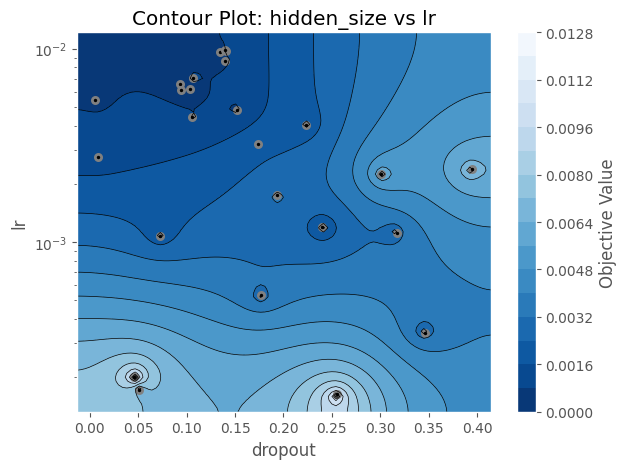

In [ ]:
from optuna.visualization.matplotlib import plot_contour
import matplotlib.pyplot as plt

fig = plot_contour(
    study,
    params=["lr", "dropout"]   # you can swap in any two/three
)
plt.title("Contour Plot: hidden_size vs lr")
plt.tight_layout()
plt.show()

In [ ]:
obs_df['variable'].value_counts()

,count
variable,
Discharge_CMS,155813
HoboWetDry0.05,2785
MaxDepth_Censor,540
MaxDepth_Threshold,540
MaxDepth_cm,533
Flow_Status,525


In [11]:
# Filter only HOBO WetDry rows
hobo_df = obs_df[obs_df["variable"] == "HoboWetDry0.05"]

# Check how many records and what the values look like
print("Shape:", hobo_df.shape)
print(hobo_df["value"].describe())
print("\nValue counts:")
print(hobo_df["value"].value_counts(dropna=False).head(20))


Shape: (2785, 5)
count    2785.000000
mean        0.856373
std         0.350774
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: value, dtype: float64

Value counts:
value
1.0    2385
0.0     400
Name: count, dtype: int64


In [12]:
seq_len = 30  # or shorter if your sites are small
target_col = "HoboWetDry0.05"

# Filter only rows with valid target values
valid_obs = obs_df[obs_df["variable"] == target_col].dropna(subset=["value"])

# Find sites that have both 0 and 1
site_variation = valid_obs.groupby("NHDPlusID")["value"].nunique()
sites_with_both = site_variation[site_variation > 1].index.tolist()
print(f"{len(sites_with_both)} sites have both wet/dry data")

# Merge only those sites
merged_sub = merged_df[merged_df["NHDPlusID"].isin(sites_with_both)].dropna(subset=[target_col])

# Recreate sequences
X_all, y_all = [], []
for sid, sdf in merged_sub.groupby("NHDPlusID"):
    sdf = sdf.sort_values("Date")
    if len(sdf) > seq_len:
        X_site, y_site = create_sequences(sdf, seq_len=seq_len)
        X_all.append(X_site)
        y_all.append(y_site)

import numpy as np
X = np.concatenate(X_all)
y = np.concatenate(y_all)

print("Final dataset:", X.shape, " Positives:", int((y > 0.5).sum()), " Negatives:", int((y <= 0.5).sum()))

# Convert to tensors (binary target)
import torch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor((y > 0.5).astype(int), dtype=torch.float32).unsqueeze(1)


6 sites have both wet/dry data
Final dataset: (535, 30, 24)  Positives: 179  Negatives: 356


Train: torch.Size([428, 30, 24]) Val: torch.Size([107, 30, 24])
Epoch 1/10 | Train Loss: 0.499161
Epoch 2/10 | Train Loss: 0.390575
Epoch 3/10 | Train Loss: 0.386940
Epoch 4/10 | Train Loss: 0.372013
Epoch 5/10 | Train Loss: 0.387913
Epoch 6/10 | Train Loss: 0.382386
Epoch 7/10 | Train Loss: 0.377581
Epoch 8/10 | Train Loss: 0.374294
Epoch 9/10 | Train Loss: 0.368476
Epoch 10/10 | Train Loss: 0.378443

TRAIN METRICS
Acc 0.813 | Prec 1.000 | Rec 0.412 | F1 0.583 | AUC 0.890
Confusion Matrix:
 [[292   0]
 [ 80  56]]

VAL METRICS
Acc 0.804 | Prec 0.958 | Rec 0.535 | F1 0.687 | AUC 0.839
Confusion Matrix:
 [[63  1]
 [20 23]]


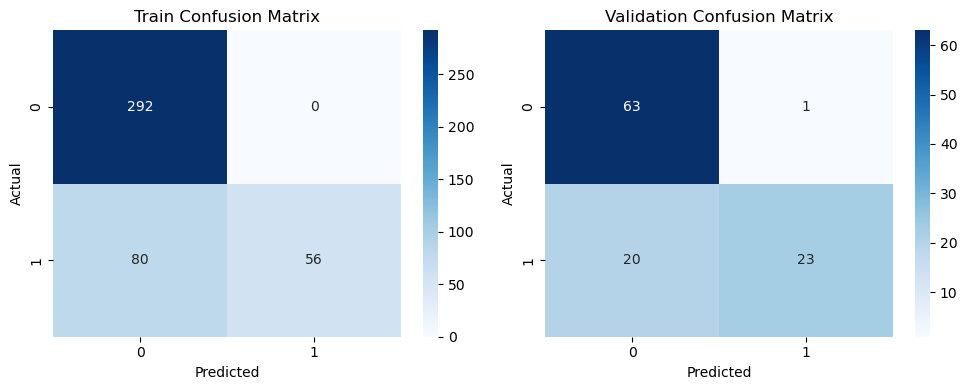

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- split ---
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape)

# --- best params from Optuna ---
best_params = {
    'hidden_size': 59,
    'num_layers': 3,
    'dropout': 0.09950596812838995,
    'lr': 0.007731509603849356,
    'batch_size': 12
}

# --- LSTM model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

model = LSTMModel(
    input_size=X_tensor.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=best_params['batch_size'], shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=best_params['batch_size'], shuffle=False)

# --- training (10 epochs) ---
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.6f}")

# --- predictions helper ---
def get_predictions(loader):
    preds, actuals = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            p = model(xb).squeeze().cpu().numpy()
            preds.append(p)
            actuals.append(yb.squeeze().cpu().numpy())
    return np.concatenate(preds), np.concatenate(actuals)

train_preds, train_actuals = get_predictions(train_loader)
val_preds,   val_actuals   = get_predictions(val_loader)

# --- classification threshold ---
thr = 0.5
train_cls = (train_preds > thr).astype(int)
val_cls   = (val_preds > thr).astype(int)

# --- metrics ---
def evaluate(y_true, y_prob, y_pred):
    cm   = confusion_matrix(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    return cm, acc, prec, rec, f1, auc

train_cm, train_acc, train_prec, train_rec, train_f1, train_auc = evaluate(train_actuals, train_preds, train_cls)
val_cm,   val_acc,   val_prec,   val_rec,   val_f1,   val_auc   = evaluate(val_actuals, val_preds, val_cls)

# --- results ---
print("\nTRAIN METRICS")
print(f"Acc {train_acc:.3f} | Prec {train_prec:.3f} | Rec {train_rec:.3f} | F1 {train_f1:.3f} | AUC {train_auc:.3f}")
print("Confusion Matrix:\n", train_cm)

print("\nVAL METRICS")
print(f"Acc {val_acc:.3f} | Prec {val_prec:.3f} | Rec {val_rec:.3f} | F1 {val_f1:.3f} | AUC {val_auc:.3f}")
print("Confusion Matrix:\n", val_cm)

# --- visualize confusion matrices ---
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Train Confusion Matrix'); ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('Actual')

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Validation Confusion Matrix'); ax[1].set_xlabel('Predicted'); ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()


In [15]:


import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# --- Split dataset ---
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42
)

# --- Define LSTM model class ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

# --- Define Optuna objective ---
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.0, 0.4)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs      = 7 # short tuning run

    model = LSTMModel(
        input_size=X_tensor.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    )
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=batch_size, shuffle=False)

    # --- training ---
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # --- validation ---
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            p = model(xb).squeeze().cpu().numpy()
            preds.append(p)
            actuals.append(yb.squeeze().cpu().numpy())

    preds = np.concatenate(preds)
    actuals = np.concatenate(actuals)

    if len(np.unique(actuals)) < 2:
        return 1.0  # meaningless trial

    auc = roc_auc_score(actuals, preds)
    return 1 - auc  # minimize (1 - AUC)

# --- run Optuna study (8 trials) ---
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials = 7)

print("\n✅ Best Hyperparameters:")
print(study.best_params)
print(f"Best Validation AUC: {1 - study.best_value:.4f}")


[I 2026-02-15 14:01:49,693] A new study created in memory with name: no-name-0e00f0f7-6e5c-4412-9810-eb04add31374
/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.282356292889873 and num_layers=1
  warnings.warn(
[W 2026-02-15 14:01:55,967] Trial 0 failed with parameters: {'hidden_size': 46, 'num_layers': 1, 'dropout': 0.282356292889873, 'lr': 0.001319676220604927, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_99523/853848040.py", line 55, in objective
    loss.backward()
  File "/opt/anaconda3/env

KeyboardInterrupt: 

In [ ]:
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate,
    plot_contour
)



/tmp/ipython-input-1560214404.py:4: ExperimentalWarning:

optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.



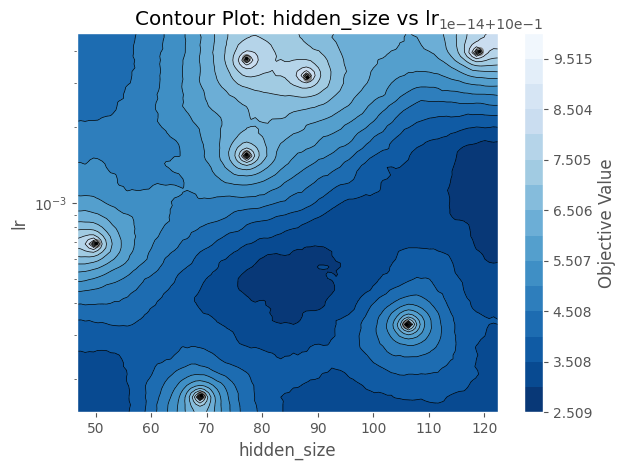

In [ ]:
from optuna.visualization.matplotlib import plot_contour
import matplotlib.pyplot as plt

fig = plot_contour(
    study,
    params=["hidden_size", "lr"]   # you can swap in any two/three
)
plt.title("Contour Plot: hidden_size vs lr")
plt.tight_layout()
plt.show()



In [ ]:
fig = plot_param_importances(study)
fig.show()



[W 2025-12-11 06:25:22,706] Study instance does not contain completed trials.


/tmp/ipython-input-642520817.py:4: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_parallel_coordinate(


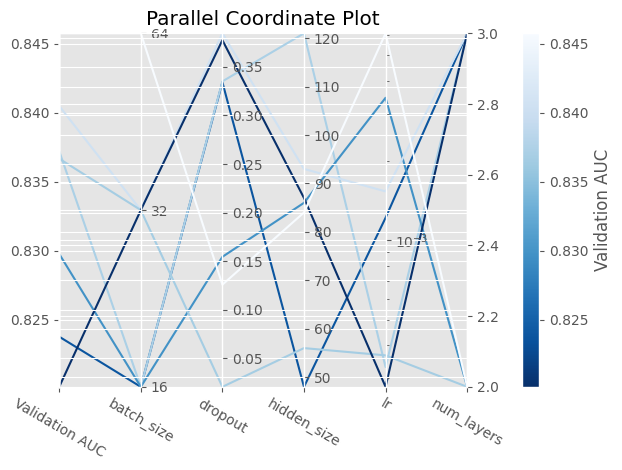

In [ ]:
from optuna.visualization.matplotlib import plot_parallel_coordinate
import matplotlib.pyplot as plt

fig = plot_parallel_coordinate(
    study,
    params=["hidden_size", "num_layers", "dropout", "lr", "batch_size"],
    target=lambda t: 1.0 - t.value,   # convert back from (1 - AUC) to AUC
    target_name="Validation AUC"
)
plt.tight_layout()
plt.show()


## Run Below

Train: torch.Size([428, 30, 24]) Val: torch.Size([107, 30, 24])


/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18844399729453062 and num_layers=1
  warnings.warn(


Epoch 1/10 | Train Loss: 0.697567
Epoch 2/10 | Train Loss: 0.685521
Epoch 3/10 | Train Loss: 0.673076
Epoch 4/10 | Train Loss: 0.662345
Epoch 5/10 | Train Loss: 0.649987
Epoch 6/10 | Train Loss: 0.637513
Epoch 7/10 | Train Loss: 0.623482
Epoch 8/10 | Train Loss: 0.611230
Epoch 9/10 | Train Loss: 0.595891
Epoch 10/10 | Train Loss: 0.583552

TRAIN METRICS
Acc 0.813 | Prec 1.000 | Rec 0.412 | F1 0.583 | AUC 0.864
Confusion Matrix:
 [[292   0]
 [ 80  56]]

VAL METRICS
Acc 0.804 | Prec 0.958 | Rec 0.535 | F1 0.687 | AUC 0.840
Confusion Matrix:
 [[63  1]
 [20 23]]


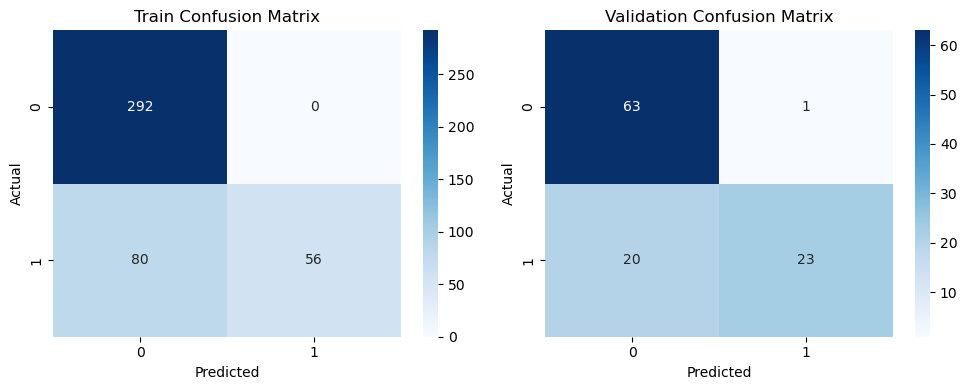

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- train/validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape)

# --- best hyperparameters from Optuna ---
best_params = {
    'hidden_size': 45,
    'num_layers': 1,
    'dropout': 0.18844399729453062,
    'lr': 0.00010354536596373893,
    'batch_size': 32
}

# --- define model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

model = LSTMModel(
    input_size=X_tensor.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=best_params['batch_size'], shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   y_val),
                          batch_size=best_params['batch_size'], shuffle=False)

# --- training (10 epochs) ---
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.6f}")

# --- prediction helper ---
def get_preds(loader):
    preds, actuals = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            p = model(xb).squeeze().cpu().numpy()
            preds.append(p)
            actuals.append(yb.squeeze().cpu().numpy())
    return np.concatenate(preds), np.concatenate(actuals)

train_p, train_y = get_preds(train_loader)
val_p,   val_y   = get_preds(val_loader)

thr = 0.5
train_c = (train_p > thr).astype(int)
val_c   = (val_p > thr).astype(int)

# --- evaluation metrics ---
def evaluate(y_true, y_prob, y_pred):
    cm   = confusion_matrix(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    return cm, acc, prec, rec, f1, auc

train_cm, train_acc, train_prec, train_rec, train_f1, train_auc = evaluate(train_y, train_p, train_c)
val_cm,   val_acc,   val_prec,   val_rec,   val_f1,   val_auc   = evaluate(val_y,   val_p,   val_c)

print("\nTRAIN METRICS")
print(f"Acc {train_acc:.3f} | Prec {train_prec:.3f} | Rec {train_rec:.3f} | F1 {train_f1:.3f} | AUC {train_auc:.3f}")
print("Confusion Matrix:\n", train_cm)

print("\nVAL METRICS")
print(f"Acc {val_acc:.3f} | Prec {val_prec:.3f} | Rec {val_rec:.3f} | F1 {val_f1:.3f} | AUC {val_auc:.3f}")
print("Confusion Matrix:\n", val_cm)

# --- visualize confusion matrices ---
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Train Confusion Matrix'); ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('Actual')

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Validation Confusion Matrix'); ax[1].set_xlabel('Predicted'); ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()


Train: torch.Size([428, 30, 24]) Val: torch.Size([107, 30, 24])
Raw pos_weight=2.15, Adjusted pos_weight=1.07


/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18844399729453062 and num_layers=1
  warnings.warn(


Epoch 1/15 | Train Loss: 0.7104 | Val Loss: 0.7072
Epoch 2/15 | Train Loss: 0.6990 | Val Loss: 0.6983
Epoch 3/15 | Train Loss: 0.6852 | Val Loss: 0.6892
Epoch 4/15 | Train Loss: 0.6744 | Val Loss: 0.6798
Epoch 5/15 | Train Loss: 0.6635 | Val Loss: 0.6705
Epoch 6/15 | Train Loss: 0.6506 | Val Loss: 0.6605
Epoch 7/15 | Train Loss: 0.6367 | Val Loss: 0.6501
Epoch 8/15 | Train Loss: 0.6280 | Val Loss: 0.6395
Epoch 9/15 | Train Loss: 0.6135 | Val Loss: 0.6280
Epoch 10/15 | Train Loss: 0.6025 | Val Loss: 0.6164
Epoch 11/15 | Train Loss: 0.5818 | Val Loss: 0.6047
Epoch 12/15 | Train Loss: 0.5706 | Val Loss: 0.5926
Epoch 13/15 | Train Loss: 0.5553 | Val Loss: 0.5807
Epoch 14/15 | Train Loss: 0.5376 | Val Loss: 0.5692
Epoch 15/15 | Train Loss: 0.5233 | Val Loss: 0.5585

Optimal threshold for balance ≈ 0.40 (Balanced Acc=0.806)

TRAIN METRICS
Acc 0.839 | Prec 0.711 | Rec 0.831 | F1 0.766 | AUC 0.847
Confusion Matrix:
 [[246  46]
 [ 23 113]]

VAL METRICS
Acc 0.813 | Prec 0.767 | Rec 0.767 | F1 0.

/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda

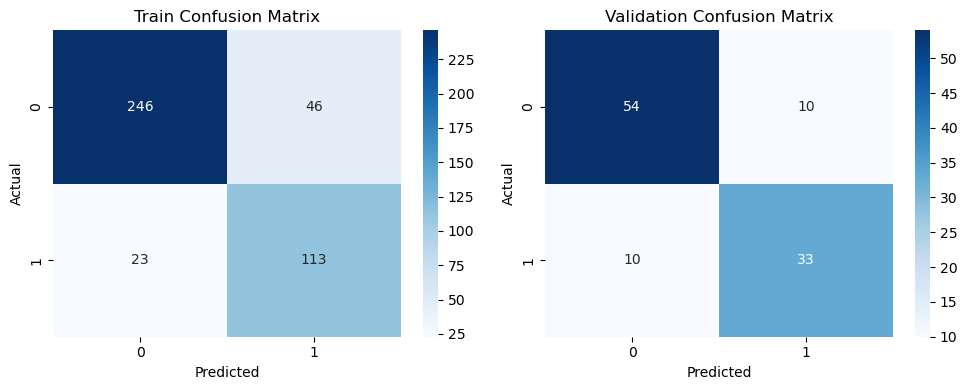

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Split data ---
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape)

# --- Adjusted positive class weight (less aggressive) ---
pos = int(y_train.sum().item())
neg = int((1 - y_train).sum().item())
raw_pos_weight = neg / max(pos, 1)
pos_weight = raw_pos_weight * 0.5
print(f"Raw pos_weight={raw_pos_weight:.2f}, Adjusted pos_weight={pos_weight:.2f}")

# --- Model hyperparameters ---
best_params = {
    'hidden_size': 45,
    'num_layers': 1,
    'dropout': 0.18844399729453062,
    'lr': 0.00010354536596373893,
    'batch_size': 32
}

# --- LSTM with logits ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel(X_tensor.shape[2], best_params['hidden_size'],
                  best_params['num_layers'], best_params['dropout'])

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], dtype=torch.float32))
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=best_params['batch_size'], shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=best_params['batch_size'], shuffle=False)

# --- Early stopping training ---
best_val_loss, patience, wait = float('inf'), 3, 0
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for xb, yb in val_loader:
            val_loss += criterion(model(xb), yb).item()
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss, wait = val_loss, 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)

# --- Predictions ---
def get_probs(loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            p = torch.sigmoid(model(xb)).squeeze().cpu().numpy()
            preds.append(p)
            actuals.append(yb.squeeze().cpu().numpy())
    return np.concatenate(preds), np.concatenate(actuals)

train_p, train_y = get_probs(train_loader)
val_p, val_y = get_probs(val_loader)

# --- Find best threshold by maximizing balanced accuracy ---
def best_balanced_threshold(y_true, y_prob):
    thresholds = np.linspace(0.05, 0.95, 91)
    best_t, best_bal = 0.5, 0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        rec = recall_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        spec = recall_score(1 - y_true, 1 - y_pred)
        bal_acc = (rec + spec) / 2
        if bal_acc > best_bal:
            best_t, best_bal = t, bal_acc
    return best_t, best_bal

thr, bal_acc = best_balanced_threshold(val_y, val_p)
print(f"\nOptimal threshold for balance ≈ {thr:.2f} (Balanced Acc={bal_acc:.3f})")

train_c = (train_p >= thr).astype(int)
val_c = (val_p >= thr).astype(int)

# --- Metrics ---
def evaluate(y_true, y_prob, y_pred):
    cm   = confusion_matrix(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    return cm, acc, prec, rec, f1, auc

train_cm, train_acc, train_prec, train_rec, train_f1, train_auc = evaluate(train_y, train_p, train_c)
val_cm,   val_acc,   val_prec,   val_rec,   val_f1,   val_auc   = evaluate(val_y,   val_p,   val_c)

print("\nTRAIN METRICS")
print(f"Acc {train_acc:.3f} | Prec {train_prec:.3f} | Rec {train_rec:.3f} | F1 {train_f1:.3f} | AUC {train_auc:.3f}")
print("Confusion Matrix:\n", train_cm)

print("\nVAL METRICS")
print(f"Acc {val_acc:.3f} | Prec {val_prec:.3f} | Rec {val_rec:.3f} | F1 {val_f1:.3f} | AUC {val_auc:.3f}")
print("Confusion Matrix:\n", val_cm)

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Train Confusion Matrix'); ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('Actual')

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Validation Confusion Matrix'); ax[1].set_xlabel('Predicted'); ax[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()


In [18]:
# --- DISCRETIZATION: Convert continuous discharge into wet/dry ---
DRY_THRESHOLD = 0.00014   # per Jake's message

# Create a new binary column from discharge
merged_df["wetdry_discharge"] = (merged_df["Discharge_CMS"] >= DRY_THRESHOLD).astype(int)

print("Wet/dry (from discharge) distribution:")
print(merged_df["wetdry_discharge"].value_counts())


Wet/dry (from discharge) distribution:
wetdry_discharge
0    140533
1     18070
Name: count, dtype: int64


In [19]:
# --- Combine HOBO + discharge discretization ---
merged_df["wetdry_final"] = merged_df["HoboWetDry0.05"]

# Fill missing HOBO with discharge discretization
merged_df["wetdry_final"] = merged_df["wetdry_final"].fillna(merged_df["wetdry_discharge"])

print("Final combined wet/dry distribution:")
print(merged_df["wetdry_final"].value_counts())


Final combined wet/dry distribution:
wetdry_final
1.0    114112
0.0     44491
Name: count, dtype: int64


In [20]:
target_col = "wetdry_final"

feature_cols = [c for c in merged_df.columns
                if c not in ["Date", "NHDPlusID", target_col]]


In [21]:
DRY_THRESHOLD = 0.00014

# Create discharge-based wet/dry
merged_df["wetdry_discharge"] = (merged_df["Discharge_CMS"] >= DRY_THRESHOLD).astype(int)

# Combine HOBO + discharge discretization
merged_df["wetdry_final"] = merged_df["HoboWetDry0.05"]
merged_df["wetdry_final"] = merged_df["wetdry_final"].fillna(merged_df["wetdry_discharge"])

print("Final wet/dry distribution:")
print(merged_df["wetdry_final"].value_counts())


Final wet/dry distribution:
wetdry_final
1.0    114112
0.0     44491
Name: count, dtype: int64


In [22]:
target_col = "wetdry_final"

feature_cols = [
    c for c in merged_df.columns
    if c not in ["Date", "NHDPlusID", target_col]
]


In [23]:
# pick the sites that have both classes
valid_obs = merged_df.dropna(subset=["wetdry_final"])
site_variation = valid_obs.groupby("NHDPlusID")["wetdry_final"].nunique()
sites_with_both = site_variation[site_variation > 1].index.tolist()

# pick one or all sites
site_df = merged_df[merged_df["NHDPlusID"].isin(sites_with_both)].sort_values("Date")


In [24]:
df = site_df.copy()

# 1. Fill all NaNs per feature
df = df.fillna(method='ffill').fillna(method='bfill')

# 2. If any remain (because entire column missing early)
df = df.fillna(0)


/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_99523/2849538801.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np
# 1. Keep numeric only
df_numeric = df.select_dtypes(include=[np.number])

print("Dropped columns:", set(df.columns) - set(df_numeric.columns))

# 2. Scale
scaler = StandardScaler()
scaled = scaler.fit_transform(df_numeric.values)
df_scaled = pd.DataFrame(scaled, columns=df_numeric.columns)


Dropped columns: {'Date', 'NHDPlusID'}


In [26]:
target_col = "wetdry_final"  # adjust to correct name

y = df[target_col].values
df = df.drop(columns=[target_col])


In [27]:
df_numeric = df.select_dtypes(include=[np.number])


In [28]:
print("Remaining NaNs:", df_numeric.isna().sum().sum())
print(df_numeric.shape)
print(df_scaled.shape)


Remaining NaNs: 0
(13963, 26)
(13963, 27)


In [29]:
print("df_scaled shape:", df_scaled.shape)
print("Remaining NaNs:", df_scaled.isna().sum().sum())
print("Any infinite values:", np.isinf(df_scaled.values).sum())
print("Feature variances:", df_scaled.var().values[:10], "...")   # first 10


df_scaled shape: (13963, 27)
Remaining NaNs: 0
Any infinite values: 0
Feature variances: [1.00007162 1.00007162 1.00007162 1.00007162 0.         1.00007162
 1.00007162 1.00007162 1.00007162 1.00007162] ...


In [30]:
def create_sequences(df, seq_len=30, target_col="wetdry_final"):
    X, y = [], []
    values = df.values
    labels = df[target_col].values

    for i in range(len(df) - seq_len):
        seq = values[i:i+seq_len]
        target = labels[i+seq_len]

        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)


In [31]:
target_col = "wetdry_final"  # CHANGE THIS IF NEEDED


In [32]:
y_original = site_df[target_col].astype(int).values


In [33]:
df_scaled_with_label = df_scaled.copy()
df_scaled_with_label[target_col] = y_original


In [34]:
X, y = create_sequences(site_df, seq_len=30)


In [35]:
# ===========================================
# 1. Clean site_df
# ===========================================
df = site_df.copy()
df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)

target_col = "wetdry_final"     # <----- your label
y_original = df[target_col].astype(int).values

# ===========================================
# 2. Select numeric features only (remove date)
# ===========================================
df_numeric = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')

# ===========================================
# 3. Scale features
# ===========================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(scaled, columns=df_numeric.columns)

# ===========================================
# 4. Add label back
# ===========================================
df_scaled_with_label = df_scaled.copy()
df_scaled_with_label[target_col] = y_original

print("df_scaled_with_label shape:", df_scaled_with_label.shape)

# ===========================================
# 5. Build sequences
# ===========================================
X, y = create_sequences(df_scaled_with_label, seq_len=30, target_col=target_col)

print("NaNs in X:", np.isnan(X).sum())
print("NaNs in y:", np.isnan(y).sum())
print("Shapes:", X.shape, y.shape)


df_scaled_with_label shape: (13963, 27)
NaNs in X: 0
NaNs in y: 0
Shapes: (13933, 30, 27) (13933,)


/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_99523/1633926387.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)


In [36]:
from imblearn.over_sampling import ADASYN


In [37]:
n, T, d = X.shape

# Flatten sequences: (n, T, d) -> (n, T*d)
X_flat = X.reshape(n, T * d)

adasyn = ADASYN(random_state=42)
X_flat_res, y_res = adasyn.fit_resample(X_flat, y.astype(int))

# Reshape back to (n_resampled, T, d)
X_res = X_flat_res.reshape(-1, T, d)

print("Original class counts:", np.bincount(y.astype(int)))
print("After ADASYN:", np.bincount(y_res.astype(int)))
print("Original shape:", X.shape, "Resampled shape:", X_res.shape)



Original class counts: [12583  1350]
After ADASYN: [12583 12547]
Original shape: (13933, 30, 27) Resampled shape: (25130, 30, 27)


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# =======================
# Convert to tensors (use ADASYN output)
# =======================
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res.reshape(-1, 1), dtype=torch.float32)

print("X_tensor:", X_tensor.shape)
print("y_tensor:", y_tensor.shape)


X_tensor: torch.Size([25130, 30, 27])
y_tensor: torch.Size([25130, 1])


In [42]:
X_train

tensor([[[-1.9779e-01, -1.7003e-01,  1.7173e-01,  ..., -3.7343e-02,
           0.0000e+00,  0.0000e+00],
         [-1.9447e-01, -1.7003e-01,  1.7173e-01,  ..., -3.7343e-02,
           0.0000e+00,  0.0000e+00],
         [-1.9771e-01, -1.7003e-01,  1.7173e-01,  ..., -3.7343e-02,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 1.8424e+01,  4.2079e+00,  1.7173e-01,  ..., -3.7128e+00,
           0.0000e+00,  8.6606e-01],
         [-1.8190e-01,  4.2079e+00,  1.7173e-01,  ..., -3.7343e-02,
           0.0000e+00,  8.6606e-01],
         [-3.0855e-01,  4.8850e+00,  1.7173e-01,  ..., -4.3288e-01,
           0.0000e+00,  1.0000e+00]],

        [[-3.0720e-01,  4.8580e+00,  1.7173e-01,  ..., -4.3077e-01,
           0.0000e+00,  9.9466e-01],
         [-3.0731e-01,  4.8580e+00,  1.7173e-01,  ..., -4.3077e-01,
           0.0000e+00,  9.9466e-01],
         [ 2.1192e+01,  4.8580e+00,  1.7173e-01,  ..., -4.2585e+00,
           0.0000e+00,  9.9466e-01],
         ...,
         [-2.3934e-01,  4

In [43]:
y_train

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [1.],
        [1.]])

In [39]:



# =======================
# Train/Val split
# =======================
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, shuffle=True, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

# =======================
# Compute pos_weight safely
# =======================
pos = int(y_train.sum().item())
neg = int((1 - y_train).sum().item())
safe_pos_weight = 1.0  # KEEP MILD FOR NOW

print("safe_pos_weight =", safe_pos_weight)
pos_weight_tensor = torch.tensor([safe_pos_weight], dtype=torch.float32)

# =======================
# Define LSTM Model
# =======================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=48, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        logits = self.fc(out[:, -1, :])
        return logits


model = LSTMModel(X_tensor.shape[2])

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)

# =======================
# Train with early stopping
# =======================
best_val_loss = float("inf")
best_state = None
patience = 3
wait = 0
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        logits = model(xb)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)

        loss = criterion(logits, yb)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    # ---- validation loss ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
            val_loss += criterion(logits, yb).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss={total_loss/len(train_loader):.4f} | Val Loss={val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict().copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)
print("Loaded best model state.")


Train: torch.Size([20104, 30, 27]) Val: torch.Size([5026, 30, 27])
safe_pos_weight = 1.0


/opt/anaconda3/envs/hbmv_2/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/15 | Train Loss=0.3141 | Val Loss=0.1435
Epoch 2/15 | Train Loss=0.1001 | Val Loss=0.0924
Epoch 3/15 | Train Loss=0.0635 | Val Loss=0.0685
Epoch 4/15 | Train Loss=0.0512 | Val Loss=0.0675
Epoch 5/15 | Train Loss=0.0471 | Val Loss=0.0620
Epoch 6/15 | Train Loss=0.0451 | Val Loss=0.0587
Epoch 7/15 | Train Loss=0.0415 | Val Loss=0.0636
Epoch 8/15 | Train Loss=0.0449 | Val Loss=0.0531
Epoch 9/15 | Train Loss=0.0388 | Val Loss=0.0543
Epoch 10/15 | Train Loss=0.0371 | Val Loss=0.0512
Epoch 11/15 | Train Loss=0.0369 | Val Loss=0.0482
Epoch 12/15 | Train Loss=0.0372 | Val Loss=0.0433
Epoch 13/15 | Train Loss=0.0349 | Val Loss=0.0510
Epoch 14/15 | Train Loss=0.0344 | Val Loss=0.0508
Epoch 15/15 | Train Loss=0.0328 | Val Loss=0.0486
Early stopping triggered.
Loaded best model state.



TRAIN METRICS
[[ 9818   193]
 [   54 10039]] 0.9877138877835256 0.981137607505864 0.9946497572575052 0.9878474784747847 0.9994785781216804

VAL METRICS
[[2512   60]
 [  11 2443]] 0.9858734580183048 0.9760287654814223 0.9955175224123879 0.9856768206576558 0.9990546110644253


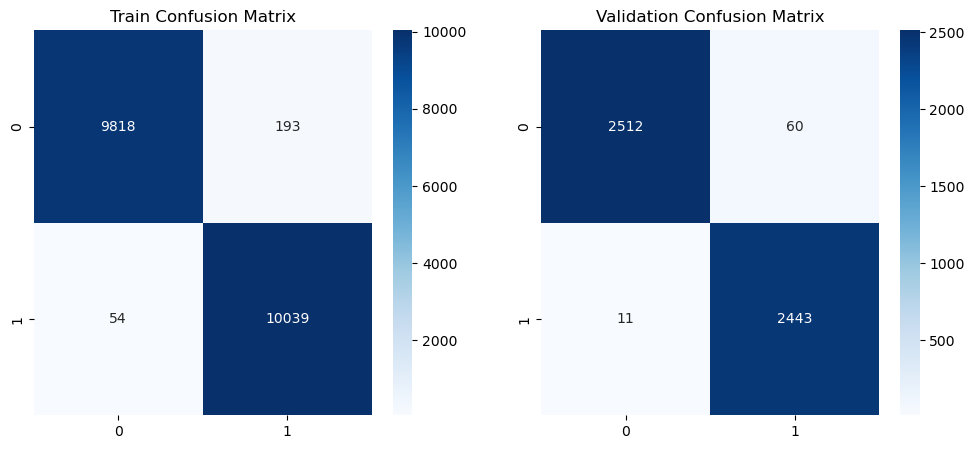

In [41]:
# =======================
# Predict safely
# =======================
def get_probs(loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0)

            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            probs = np.nan_to_num(probs, nan=0.0)

            preds.append(probs)
            actuals.append(yb.squeeze().cpu().numpy())

    return np.concatenate(preds), np.concatenate(actuals)

train_probs, train_true = get_probs(train_loader)
val_probs, val_true = get_probs(val_loader)

# =======================
# Apply threshold
# =======================
threshold = 0.5
train_pred = (train_probs >= threshold).astype(int)
val_pred = (val_probs >= threshold).astype(int)

# =======================
# Compute metrics
# =======================
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_metrics(y_true, y_prob, y_pred):
    return (
        confusion_matrix(y_true, y_pred),
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, zero_division=0),
        recall_score(y_true, y_pred, zero_division=0),
        f1_score(y_true, y_pred),
        roc_auc_score(y_true, y_prob)
    )

train_cm, train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(train_true, train_probs, train_pred)
val_cm,   val_acc,   val_prec,   val_rec,   val_f1,   val_auc   = compute_metrics(val_true, val_probs, val_pred)

print("\nTRAIN METRICS")
print(train_cm, train_acc, train_prec, train_rec, train_f1, train_auc)

print("\nVAL METRICS")
print(val_cm, val_acc, val_prec, val_rec, val_f1, val_auc)

# =======================
# Plot confusion matrices
# =======================
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Train Confusion Matrix")

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title("Validation Confusion Matrix")

plt.show()


In [ ]:
import numpy as np

def get_probs(loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)

            # Remove NaNs and infinities BEFORE sigmoid
            logits = torch.nan_to_num(logits, nan=0.0, posinf=15.0, neginf=-15.0)

            probs = torch.sigmoid(logits).squeeze().cpu().numpy()

            # Remove NaNs from probabilities
            probs = np.nan_to_num(probs, nan=0.0, posinf=1.0, neginf=0.0)

            preds.append(probs)
            actuals.append(yb.squeeze().cpu().numpy())

    out_probs = np.concatenate(preds)
    out_true  = np.concatenate(actuals)

    # Clean NaNs in true labels just in case
    out_true = np.nan_to_num(out_true, nan=0.0)

    return out_probs, out_true


train_probs, train_true = get_probs(train_loader)
val_probs,   val_true   = get_probs(val_loader)

# classification threshold
threshold = 0.5
train_pred = (train_probs >= threshold).astype(int)
val_pred   = (val_probs   >= threshold).astype(int)

print("Probabilities + predictions safely computed.")


Probabilities + predictions safely computed.


In [ ]:
print("prob std:", train_probs.std())


prob std: 0.4910816


In [ ]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)
import numpy as np

# ---------------------------------------------------
# 1. GET PREDICTIONS
# ---------------------------------------------------
train_probs, train_true = get_probs(train_loader)
val_probs,   val_true   = get_probs(val_loader)

# ---------------------------------------------------
# 2. SANITIZE ALL VALUES (critical)
# ---------------------------------------------------
train_probs = np.nan_to_num(train_probs, nan=0.0, posinf=1.0, neginf=0.0)
val_probs   = np.nan_to_num(val_probs,   nan=0.0, posinf=1.0, neginf=0.0)

train_true = np.nan_to_num(train_true, nan=0.0)
val_true   = np.nan_to_num(val_true,   nan=0.0)

# ---------------------------------------------------
# 3. CHOOSE THRESHOLD
# ---------------------------------------------------
threshold = 0.5  # you can swap in your tuned threshold

train_pred = (train_probs >= threshold).astype(int)
val_pred   = (val_probs   >= threshold).astype(int)

# ---------------------------------------------------
# 4. EVALUATION FUNCTION
# ---------------------------------------------------
def compute_metrics(y_true, y_prob, y_pred):
    cm   = confusion_matrix(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float('nan')
    return cm, acc, prec, rec, f1, auc

# ---------------------------------------------------
# 5. COMPUTE TRAIN + VAL METRICS
# ---------------------------------------------------
train_cm, train_acc, train_prec, train_rec, train_f1, train_auc = \
    compute_metrics(train_true, train_probs, train_pred)

val_cm, val_acc, val_prec, val_rec, val_f1, val_auc = \
    compute_metrics(val_true, val_probs, val_pred)

# ---------------------------------------------------
# 6. PRINT METRICS
# ---------------------------------------------------
print("\n================ TRAIN METRICS ================")
print(f"Accuracy:  {train_acc:.4f}")
print(f"Precision: {train_prec:.4f}")
print(f"Recall:    {train_rec:.4f}")
print(f"F1 Score:  {train_f1:.4f}")
print(f"AUC:       {train_auc:.4f}")
print("Confusion Matrix:\n", train_cm)

print("\n================ VAL METRICS ================")
print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1 Score:  {val_f1:.4f}")
print(f"AUC:       {val_auc:.4f}")
print("Confusion Matrix:\n", val_cm)



================ TRAIN METRICS ================
Accuracy:  0.9876
Precision: 0.9830
Recall:    0.9924
F1 Score:  0.9877
AUC:       0.9995
Confusion Matrix:
 [[ 9838   173]
 [   77 10016]]

================ VAL METRICS ================
Accuracy:  0.9831
Precision: 0.9763
Recall:    0.9894
F1 Score:  0.9828
AUC:       0.9992
Confusion Matrix:
 [[2513   59]
 [  26 2428]]


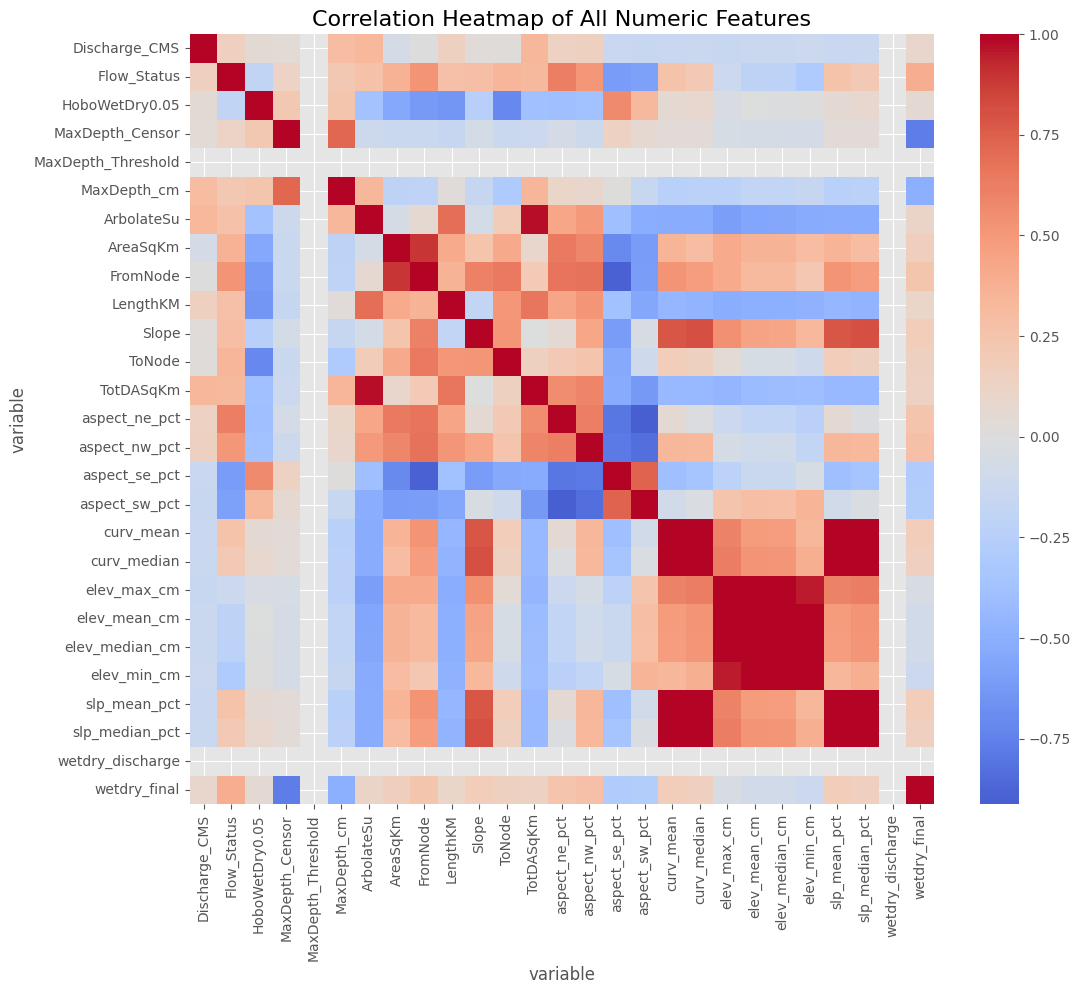

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Only numeric columns
numeric_df = df_scaled_with_label.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap of All Numeric Features", fontsize=16)
plt.show()


/tmp/ipython-input-4291603997.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr_target.index, x=corr_target.values, palette="viridis")


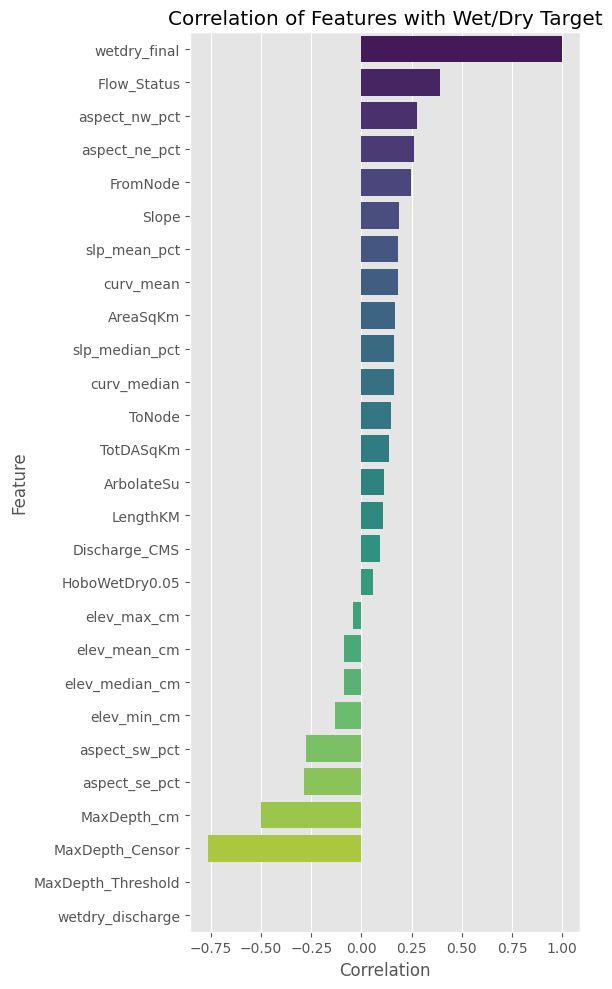

In [ ]:
corr_target = numeric_df.corr()[target_col].sort_values(ascending=False)

plt.figure(figsize=(6,10))
sns.barplot(y=corr_target.index, x=corr_target.values, palette="viridis")
plt.title("Correlation of Features with Wet/Dry Target")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


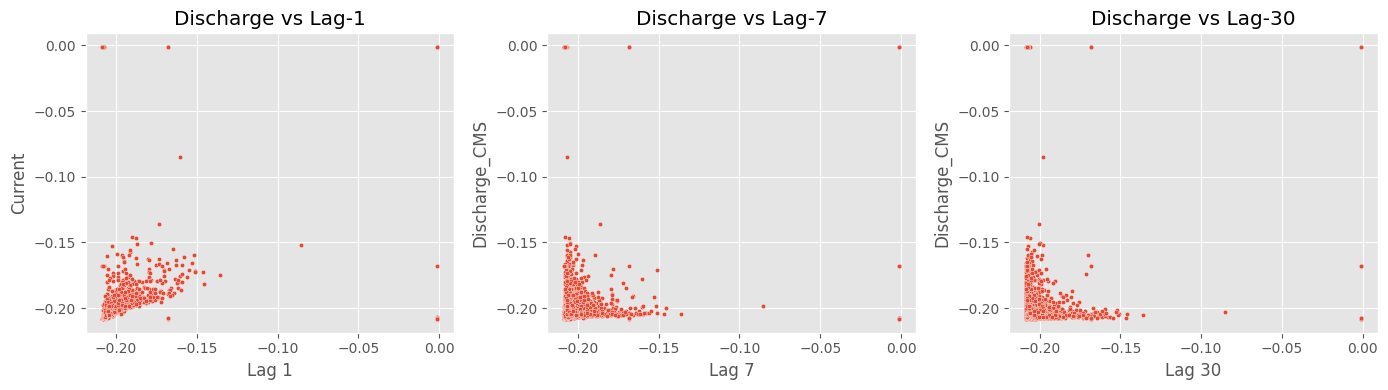

In [ ]:
df = site_df.copy()
df = df.sort_values("Date")

df["discharge_lag1"] = df["Discharge_CMS"].shift(1)
df["discharge_lag7"] = df["Discharge_CMS"].shift(7)
df["discharge_lag30"] = df["Discharge_CMS"].shift(30)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.scatterplot(x=df["discharge_lag1"], y=df["Discharge_CMS"], s=10)
plt.title("Discharge vs Lag-1")
plt.xlabel("Lag 1")
plt.ylabel("Current")

plt.subplot(1,3,2)
sns.scatterplot(x=df["discharge_lag7"], y=df["Discharge_CMS"], s=10)
plt.title("Discharge vs Lag-7")
plt.xlabel("Lag 7")

plt.subplot(1,3,3)
sns.scatterplot(x=df["discharge_lag30"], y=df["Discharge_CMS"], s=10)
plt.title("Discharge vs Lag-30")
plt.xlabel("Lag 30")

plt.tight_layout()
plt.show()


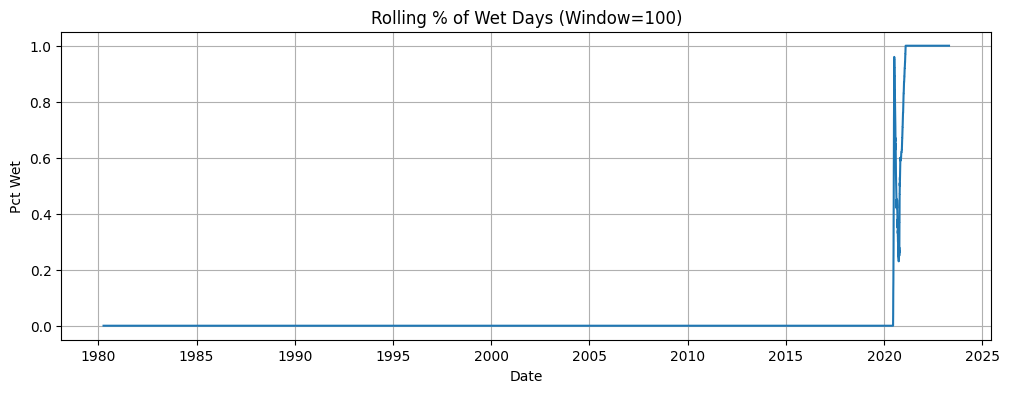

In [ ]:
 df = site_df.copy().sort_values("Date")

df["rolling_wet"] = df[target_col].rolling(100).mean()

plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["rolling_wet"])
plt.title("Rolling % of Wet Days (Window=100)")
plt.ylabel("Pct Wet")
plt.xlabel("Date")
plt.grid(True)
plt.show()


/tmp/ipython-input-3211329192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette="plasma")


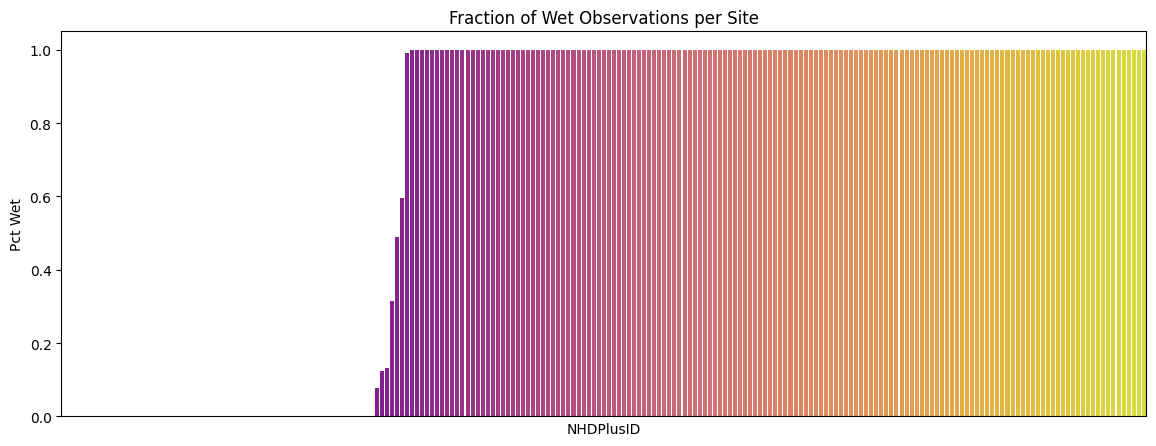

In [ ]:
counts = merged_df.groupby("NHDPlusID")[target_col].mean().sort_values()

plt.figure(figsize=(14,5))
sns.barplot(x=counts.index.astype(str), y=counts.values, palette="plasma")
plt.xticks([], [])  # hide long site IDs
plt.title("Fraction of Wet Observations per Site")
plt.ylabel("Pct Wet")
plt.show()


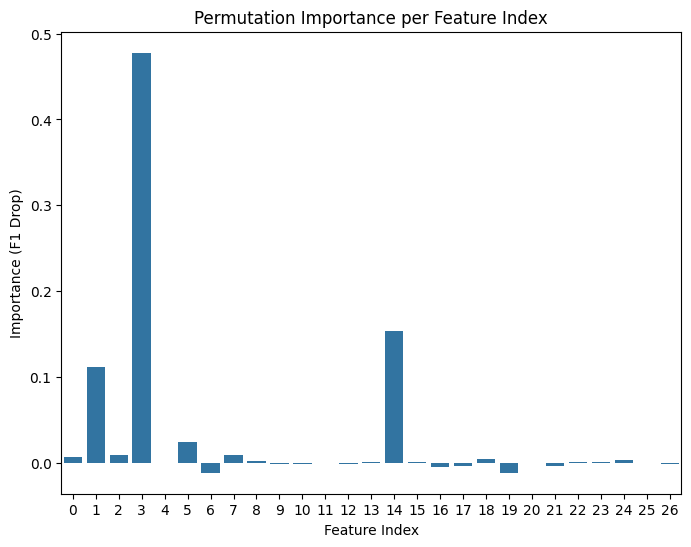

In [ ]:
import numpy as np

def perm_importance(model, X_val, y_val, n_repeats=5):
    base_preds = torch.sigmoid(model(X_val)).detach().cpu().numpy()
    base_f1 = f1_score(y_val, (base_preds>0.5))

    importances = []

    for col in range(X_val.shape[2]):
        f1_scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.clone()
            X_permuted[:,:,col] = X_val[:,:,col][torch.randperm(X_val.shape[0])]
            perm_preds = torch.sigmoid(model(X_permuted)).detach().cpu().numpy()
            f1_scores.append(f1_score(y_val, (perm_preds>0.5)))
        importances.append(base_f1 - np.mean(f1_scores))

    return np.array(importances)

imps = perm_importance(model, X_val, y_val.squeeze().numpy())
plt.figure(figsize=(8,6))
sns.barplot(x=np.arange(len(imps)), y=imps)
plt.title("Permutation Importance per Feature Index")
plt.xlabel("Feature Index")
plt.ylabel("Importance (F1 Drop)")
plt.show()


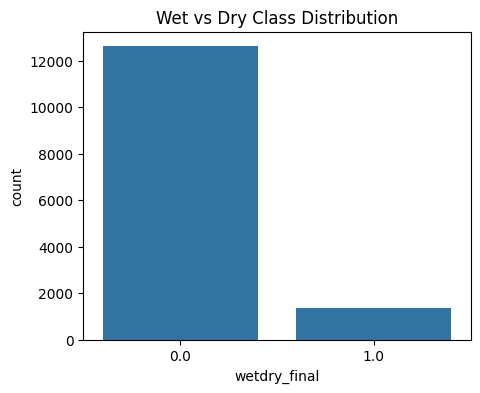

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=site_df[target_col])
plt.title("Wet vs Dry Class Distribution")
plt.show()


In [ ]:
!pip install imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import torch

# Pivot static vars once
static_wide = static_vars_df.pivot(
    index='NHDPlusID', columns='variable', values='value'
).reset_index()

# Pivot obs (Date + variable -> wide)
obs_wide = obs_df.pivot_table(
    index=['NHDPlusID','Date'], columns='variable', values='value'
).reset_index()

# Merge static + obs
merged_df = obs_wide.merge(static_wide, on='NHDPlusID', how='left')

# Sort and forward-fill (per site)
merged_df = merged_df.sort_values(['NHDPlusID','Date'])
merged_df = merged_df.groupby('NHDPlusID').ffill()

print("Merged DF shape:", merged_df.shape)


Merged DF shape: (158603, 26)


In [ ]:
DRY_THRESHOLD = 0.00014

merged_df["wetdry_discharge"] = (
    merged_df["Discharge_CMS"] >= DRY_THRESHOLD
).astype(int)


In [ ]:
print(merged_df["wetdry_discharge"].value_counts())


wetdry_discharge
1    150156
0      8447
Name: count, dtype: int64


In [ ]:
print(merged_df.columns.tolist())


['Date', 'Discharge_CMS', 'Flow_Status', 'HoboWetDry0.05', 'MaxDepth_Censor', 'MaxDepth_Threshold', 'MaxDepth_cm', 'ArbolateSu', 'AreaSqKm', 'FromNode', 'LengthKM', 'Slope', 'ToNode', 'TotDASqKm', 'aspect_ne_pct', 'aspect_nw_pct', 'aspect_se_pct', 'aspect_sw_pct', 'curv_mean', 'curv_median', 'elev_max_cm', 'elev_mean_cm', 'elev_median_cm', 'elev_min_cm', 'slp_mean_pct', 'slp_median_pct', 'wetdry_discharge']
